In [1]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import xlogy, erf
import math as m
from matplotlib.font_manager import FontProperties
from collections import OrderedDict

In [2]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [3]:
# Compton event selection criteria
E, sigma = 440, 2 # only selecting events with energies between E-sigma and E+sigma
mu_low, mu_high = -0.4, 1 # only selecting cones with opening angles between -0.4 < costheta < 1
lever_thres = 14 # only selecting cones with lever arms r12 > 14 mm

filename = '/Users/eframe/Downloads/ac2pt_top_COMP.h5'

# Size of image reconstruction space
center = np.array( [ 0, 0, 30] ) # image space center
binSize = 1
sourceX, sourceY, sourceZ = np.mgrid[ -29:31:binSize, -29:31:binSize, -29:31:binSize ] 
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T + center

In [4]:
# Getting Compton cones from detector data for each pose
f = tables.open_file( filename, 'r' )
time = f.root.EventData.read()['timestamp']
duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) / 60
print('minutes:', duration)
d = f.root.Interactions.Double.read()
d['x'] = d['x'] - 38 
d['y'] = d['y'] - 38  
l22 = d.reshape( int ( len ( d ) / 2 ), 2 ) 

# Getting Doubles Events 
emask = ( l22['energy'].sum( axis = 1 ) >= E - sigma ) & ( l22['energy'].sum( axis = 1 ) <= E + sigma )   
events_old = l22[emask]
events = compton.correct_depth( events_old )
events['z'] = -events['z']

# Getting Compton Cone Parameters (# simple method without probabilistic gamma-ray tracking)
iP, iP2, cD, cM = compton.convertToConeData( events, E, lever_thres )

# Sequencing Interactions
energy1 = np.array( [ events['energy' ][ :, 0 ], events['energy'][ :, 1 ] ] ).T
energy2 = np.array( [ events['energy' ][ :, 1 ], events['energy'][ :, 0 ] ] ).T
p1 = np.squeeze( np.array( [ events['x'][ :, 0 ], events['y'][ :, 0 ], events['z'][ :, 0 ] ] ) ).T
p2 = np.squeeze( np.array( [ events['x'][ :, 1 ], events['y'][ :, 1 ], events['z'][ :, 1 ] ] ) ).T
pos1 = np.concatenate( ( [ p1, p2 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )
pos2 = np.concatenate( ( [ p2, p1 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )

P12, P21 = compton.sequence_probability( energy1, pos1, E )
mask = ( P12 < P21 )
energy = energy1.copy()
energy[mask] = energy2[mask]
pos = pos1.copy()
pos[mask] = pos2[mask]
iP, iP2, cD, cM = compton.convertToConeData_SEQ( energy, pos, E, lever_thres )

mask = ( cM > mu_low ) & ( cM < mu_high )
interPos = iP[mask] 
coneMu = cM[mask] 
coneDir = cD[mask]

minutes: 52.48875193000001


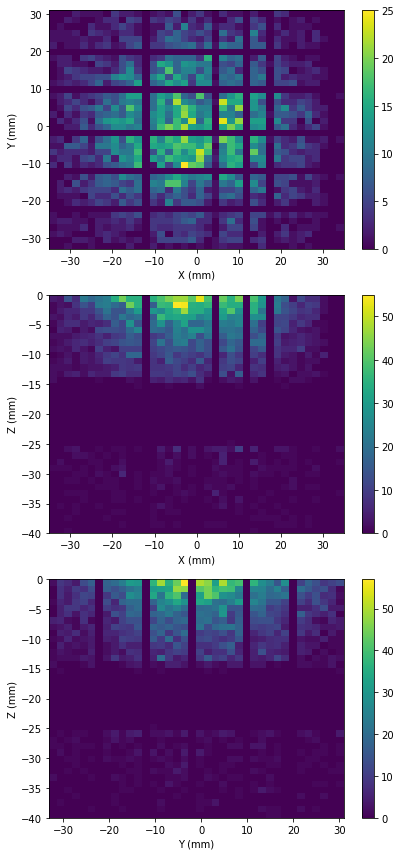

In [5]:
# Heatmap of interaction locations in detectors
get_ipython().run_line_magic('matplotlib', 'inline')   
pos = interPos
plt.figure( figsize=( 6,12 ) )
# XY
plt.subplot( 311 )
plt.hist2d( pos[ :, 0 ], pos[ :, 1 ], bins = ( 38, 38 ) )
plt.colorbar()
plt.xlabel( "X (mm)" )
plt.ylabel( "Y (mm)" )
# XZ
plt.subplot( 312 )
plt.hist2d(pos[ :, 0 ], pos[ :, 2 ], bins = ( 38, 38 ) )
plt.colorbar()
plt.xlabel( "X (mm)" )
plt.ylabel( "Z (mm)" )
# YZ
plt.subplot( 313 )
plt.hist2d(pos[ :, 1 ], pos[ :, 2 ], bins = ( 38, 38 ) )
plt.colorbar()
plt.xlabel( "Y (mm)" )
plt.ylabel( "Z (mm)" )
# Render
plt.tight_layout()
plt.show()

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)
/Users/eframe/dmi/src/compton.py:155: RuntimeWarning: divide by zero encountered in true_divide
  (erf((1 + mu_3) / np.sqrt(2) / Sig_3) + erf((1 - mu_3) / np.sqrt(2) / Sig_3)) / \


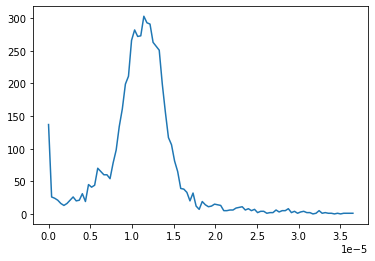

In [6]:
# Getting Backprojected Weights (THIS is the system response)
dtheta = 0.1 # uncertainty in opening angle of Compton cone (related to angular resolution of imager)
bp = compton.coneVoxel2( sourcePixels, interPos, coneDir, coneMu, dtheta, binSize  ) 
v = ( bp ).sum( 1 )
mask2 = np.isnan( v ) | ( v < 1e-20 )
backproj = bp[~mask2] 
hist, bins = np.histogram( v[~mask2], bins = 100 )
plt.plot( bins[ :-1 ], hist )
plt.show()

In [ ]:
# Graphing the Optimal Open Fraction vs. Source Distribution 
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel(r'Total Probability Density Function, $t_i = \sum_{j}^J w_{ij}$', fontsize=40, fontproperties=font, labelpad=0)
ax.set_ylabel('Number of Compton Cones', fontsize=40, fontproperties=font, labelpad=20)
ax.plot( bins[:-1], hist, 'k', linestyle = linestyles['solid'], linewidth=4 )
ax.axvline( 1e-6, color='red', 
           linestyle = linestyles['densely dashed'], linewidth=4, label=r'Threshold, $T=1e-6$')
ax.tick_params(labelsize=40)
ax.xaxis.get_offset_text().set_fontsize(30)
ax.xaxis.get_offset_text().set_family("Times New Roman")
ax.set_xlim(-1e-6,2.5e-5)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
legend = ax.legend(prop={"family":"Times New Roman", 'size': 30} )
plt.show()

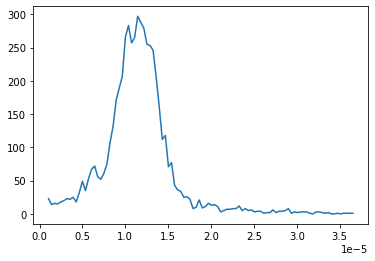

In [7]:
# Removing Compton cones that barely intersect image reconstruction space  
%matplotlib inline
v = ( backproj ).sum( 1 )
mask = v > 1e-6
hist, bins = np.histogram( v[mask], bins = 100 )
backproj_New = backproj[mask] 
plt.plot( bins[ :-1 ], hist )
plt.show()

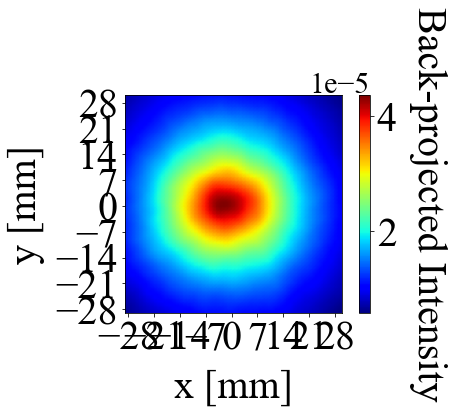

In [8]:
%matplotlib inline
sensval = np.array(backproj_New).sum(0).reshape(sourceX.shape).sum(2)
# a, b = min(sensval.flatten()), max(sensval.flatten())
sX, sZ = np.mgrid[ -29:31:binSize, -29:31:binSize ]
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
# grid = sensval[ :, :, 1] 
grid = sensval[ :, : ]
im = ax.pcolormesh( sX, sZ, grid, cmap='jet', shading = 'gouraud' ) 
ax.tick_params(labelsize=150)
ax.set_xlabel('x [mm]', fontsize=40, fontproperties=font, labelpad=10)
ax.set_ylabel('y [mm]', fontsize=40, fontproperties=font, labelpad=10)
ax.set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im)
cbar.set_label(label=r'Back-projected Intensity', rotation=270, fontsize=40, fontproperties=font, labelpad=50)
cbar.ax.tick_params(labelsize=40)
ax.xaxis.set_ticks(np.arange(-28, 30, 7))
ax.yaxis.set_ticks(np.arange(-28, 30, 7))
cbar.ax.yaxis.get_offset_text().set_fontsize(30)
cbar.ax.yaxis.get_offset_text().set_family("Times New Roman")
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
plt.show()

In [ ]:
# Showing the Image Reconstruction
%matplotlib inline
depth = np.array( sourceZ[:,0][0] )[:] + center[2]
xmin, xmax = sourceX[:,0][:,0][0], sourceX[:,0][:,0][-1] + 1
ymin, ymax = sourceY[0,:][:,0][0], sourceY[0,:][:,0][-1] + 1
X, Y = np.mgrid[  xmin:xmax:binSize, ymin:ymax:binSize ]

lamb2 = lamb.copy()
lamb2 = np.fliplr( lamb2.reshape(sourceX.shape)[:,:,:] )
a, b = min(lamb2.flatten()), max(lamb2.flatten())

for i in np.arange( lamb2.shape[2] ):
    fig, ax = plt.subplots()
    grid = lamb2[ :, :, i] 
    im = ax.pcolormesh( X, Y, grid, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.title( depth[i] )
    print('z (mm):', depth[i])
    plt.show()

In [ ]:
# Calculating Sensitivity Map 
sensMap = []
eps = 1e-10
det = 37

x = np.round( sourcePixels[:,0]  ).astype(int)
y = np.round( sourcePixels[:,1] ).astype(int)
z = np.round( sourcePixels[:,2] ).astype(int)
R = np.sqrt( x ** 2 + y ** 2 + z ** 2)
rHat = sourcePixels / R[:,np.newaxis]
c1 = x + det
c2 = x - det
d1 = y + det
d2 = y - det
a1 = c1 / ( np.sqrt( c1 ** 2 + z ** 2 ) + eps )
b1 = d1 / ( np.sqrt( d1 ** 2 + z ** 2 ) + eps )
a2 = c2 / ( np.sqrt( c2 ** 2 + z ** 2 ) + eps )
b2 = d2 / ( np.sqrt( d2 ** 2 + z ** 2 ) + eps )
firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) 
sens[z<0]=0
sensMap.append( sens )
sens = np.array( sensMap ).sum(0)

In [ ]:
# Heatmap of sensitivity
sens_grid = sens.reshape( sourceX.shape )
a, b = min(sens_grid.flatten()), max(sens_grid.flatten())
for i in np.arange( sourceX.shape[2] ):
    fig, ax = plt.subplots()
    grid = sens_grid[ :, :, i] 
    im = ax.pcolormesh( grid.T, vmin=a, vmax=b, shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'z (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.show()

In [ ]:
nIter = 10 # number of iterations
eps = 0.01 # tikhonov regularization parameter
lamb = np.ones( len( sourcePixels ) )
for i in np.arange( nIter ):
    print( 'iteration: %i' %i )
    sysMat = backproj_New
    projExpected = np.dot( sysMat, lamb ) 
    frac = np.divide( sysMat.T, projExpected, out = np.zeros_like( sysMat.T ), where = projExpected != 0 )
    lamb = lamb * frac.sum(1) * sens / ( sens ** 2 + max( sens ) ** 2 * eps ** 2 )

In [ ]:
# Showing the Image Reconstruction
%matplotlib inline
depth = np.array( sourceZ[:,0][0] )[:] + center[2]
xmin, xmax = sourceX[:,0][:,0][0], sourceX[:,0][:,0][-1] + 1
ymin, ymax = sourceY[0,:][:,0][0], sourceY[0,:][:,0][-1] + 1
X, Y = np.mgrid[  xmin:xmax:binSize, ymin:ymax:binSize ]

lamb2 = lamb.copy()
lamb2 = np.fliplr( lamb2.reshape(sourceX.shape)[:,:,:] )
a, b = min(lamb2.flatten()), max(lamb2.flatten())

for i in np.arange( lamb2.shape[2] ):
    fig, ax = plt.subplots()
    grid = lamb2[ :, :, i] 
    im = ax.pcolormesh( X, Y, grid, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.title( depth[i] )
    print('z (mm):', depth[i])
    plt.show()